The Goal here (pun intended) is to design a prediction system which can accurately predict if the home team will win or not. We will use the final dataset got by our earlier "Scraping and Cleaning" Notebook build our prediction model on.

In [1]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display

%matplotlib inline

In [2]:
# Read data and drop redundant column.
data = pd.read_csv('../input/football-results-and-betting-odds-data-of-epl/final_dataset.csv')

# Remove first 3 matchweeks
data = data[data.MW > 3]

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)


# Preview data.
display(data.head())

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,H,1.25,1.00,D,D,W,D,W,L,0.50,0.25,0.25,-16.0
31,NH,0.75,0.25,L,L,W,D,L,L,-0.50,-0.75,0.50,-2.0
32,H,1.00,1.00,L,D,W,D,W,L,0.00,0.25,0.00,-3.0
33,NH,0.75,0.50,L,L,W,D,L,D,-0.25,-0.25,0.25,3.0
34,NH,1.00,1.50,D,L,W,W,W,L,0.00,0.75,-0.50,3.0


## Data Exploration

In [3]:
# Total number of students.
n_matches = data.shape[0]

# Calculate number of features.
n_features = data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(data[data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 5600
Number of features: 12
Number of matches won by home team: 2603
Win rate of home team: 46.48%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efdc522c550>,
      dtype=object)

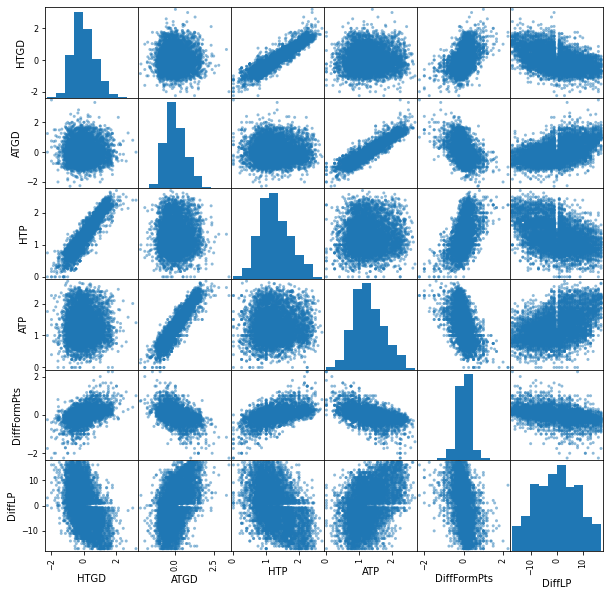

In [4]:
# Visualising distribution of data
from pandas.plotting import scatter_matrix


scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

## Preparing the Data

In [5]:
# Separate into feature set and target variable
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale


cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])
    


In [6]:
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

def preprocess_features(X):
    ''' Preprocesses the football data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (24 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [7]:
# Show the feature information by printing the first five rows
print("\nFeature values:")
display(X_all.head())


Feature values:


,HTP,ATP,HM1_D,HM1_L,HM1_W,HM2_D,HM2_L,HM2_W,HM3_D,HM3_L,...,AM2_D,AM2_L,AM2_W,AM3_D,AM3_L,AM3_W,HTGD,ATGD,DiffFormPts,DiffLP
30,-0.043829,-0.611968,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0.753719,0.355995,0.25,-1.989216
31,-1.120644,-2.238746,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,-0.737082,-1.138834,0.50,-0.248963
32,-0.582236,-0.611968,0,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0.008318,0.355995,0.00,-0.373267
33,-1.120644,-1.696487,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,-0.364382,-0.391419,0.25,0.372556
34,-0.582236,0.472551,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0.008318,1.103409,-0.50,0.372556


In [8]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_all)


## Training and Evaluating Models

In [9]:
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [10]:
# TODO: Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print('')

Training a LogisticRegression using a training set size of 5550. . .
Trained model in 0.0488 seconds
Made predictions in 0.0033 seconds.
0.6215610352557571 0.6654054054054054
F1 score and accuracy score for training set: 0.6216 , 0.6654.
Made predictions in 0.0025 seconds.
F1 score and accuracy score for test set: 0.6957 , 0.7200.

Training a SVC using a training set size of 5550. . .
Trained model in 2.1741 seconds
Made predictions in 1.2570 seconds.
0.6470216796463902 0.6978378378378378
F1 score and accuracy score for training set: 0.6470 , 0.6978.
Made predictions in 0.0139 seconds.
F1 score and accuracy score for test set: 0.7234 , 0.7400.

Training a XGBClassifier using a training set size of 5550. . .
Trained model in 0.4573 seconds
Made predictions in 0.0202 seconds.
0.9358949225642031 0.9410810810810811
F1 score and accuracy score for training set: 0.9359 , 0.9411.
Made predictions in 0.0025 seconds.
F1 score and accuracy score for test set: 0.6800 , 0.6800.



**Clearly XGBoost seems like the best model as it has the highest F1 score and accuracy score on the test set.**

# Tuning the parameters of XGBoost.

In [11]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print(clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

f1, acc = predict_labels(clf, X_test, y_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=40, n_jobs=0, num_parallel_tree=1, random_state=2,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=2,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)
Made predictions in 0.0098 seconds.
F1 score and accuracy score for training set: 0.6330 , 0.6795.
Made predictions in 0.0027 seconds.
F1 score and accuracy score for test set: 0.7234 , 0.7400.


# Fitting the model on the whole dataset for future predictions.

In [12]:
from pprint import pprint


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.03],
               'n_estimators' : [20],
               'max_depth': [5],
               'min_child_weight': [5],
               'gamma':[0.2],
               'subsample':[0.8],
               'colsample_bytree':[0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-2],
               'early_stopping_rounds':[10]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_all,y_all)

# Get the estimator
clf = grid_obj.best_estimator_
print(clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

[04:34:09] WARNING: ../src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:34:09] WARNING: ../src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:34:09] WARNING: ../src/learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if y